In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
# Load the dataset
file_path = "/Users/disastershubz/Downloads/MacroTrends_Data_Download_TSLA.csv"
df = pd.read_csv(file_path, skiprows=14)


In [10]:
# Preprocessing
df.rename(columns={"date": "ds", "close": "y"}, inplace=True)
df["ds"] = pd.to_datetime(df["ds"])
df.set_index("ds", inplace=True)
df.sort_index(inplace=True)

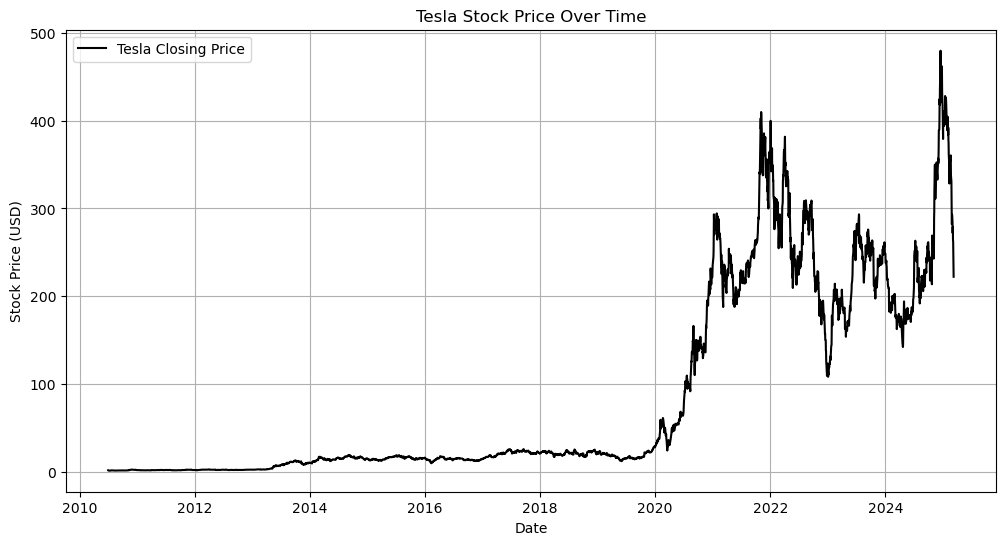

In [12]:
# Visualize stock price
plt.figure(figsize=(12,6))
plt.plot(df.index, df["y"], label="Tesla Closing Price", color="black")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Tesla Stock Price Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Check for stationarity
adf_test = adfuller(df["y"])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
if adf_test[1] < 0.05:
    print("✅ The series is stationary")
else:
    print("❌ The series is NOT stationary, applying differencing...")

ADF Statistic: -1.64161158938731
p-value: 0.46141881502264626
❌ The series is NOT stationary, applying differencing...


In [18]:
# Apply differencing to make the series stationary
df["y_diff"] = df["y"].diff()
df.dropna(inplace=True)

In [20]:
# Re-run stationarity test
adf_test_diff = adfuller(df["y_diff"])
print("ADF Statistic (After Differencing):", adf_test_diff[0])
print("p-value:", adf_test_diff[1])

ADF Statistic (After Differencing): -10.276508389074362
p-value: 3.878079122870242e-18


In [22]:
# SARIMA Model Training
sarima = SARIMAX(df["y"], order=(2,1,2), seasonal_order=(1,1,1,12))
sarima_fit = sarima.fit()
print(sarima_fit.summary())


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22516D+00    |proj g|=  5.94203D-02

At iterate    5    f=  3.11212D+00    |proj g|=  3.45167D-02

At iterate   10    f=  3.10899D+00    |proj g|=  1.45043D-02

At iterate   15    f=  3.10451D+00    |proj g|=  3.97007D-03

At iterate   20    f=  3.10439D+00    |proj g|=  4.50045D-04

At iterate   25    f=  3.10433D+00    |proj g|=  3.73813D-03

At iterate   30    f=  3.10366D+00    |proj g|=  1.84293D-03

At iterate   35    f=  3.10361D+00    |proj g|=  4.65141D-04

At iterate   40    f=  3.10355D+00    |proj g|=  9.94964D-04

At iterate   45    f=  3.10355D+00    |proj g|=  3.03548D-04


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10349D+00    |proj g|=  5.60626D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   5.606D-03   3.103D+00
  F =   3.1034888941207419     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 3696
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood              -11470.495
Date:                              Wed, 12 Mar 2025   AIC                         

In [23]:
# Get SARIMA residuals
df["residuals"] = sarima_fit.resid

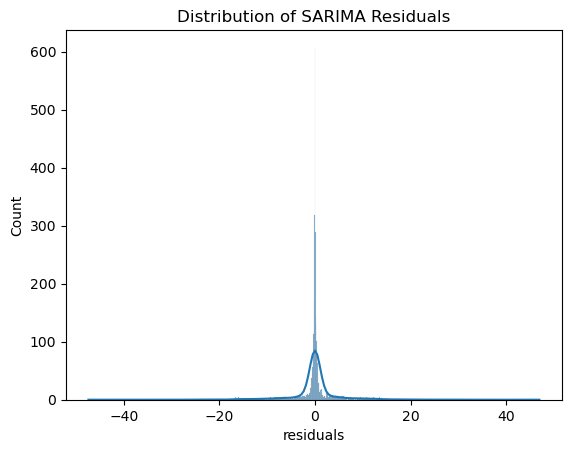

In [26]:
# Check residuals distribution
sns.histplot(df["residuals"].dropna(), kde=True)
plt.title("Distribution of SARIMA Residuals")
plt.show()

In [28]:
# Scale residuals for LSTM
scaler = MinMaxScaler()
df["residuals_scaled"] = scaler.fit_transform(df["residuals"].values.reshape(-1, 1))

In [30]:
# Create LSTM Sequences
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

In [32]:
time_steps = 60
X_lstm, y_lstm = create_sequences(df["residuals_scaled"].values, time_steps)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)


In [34]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)

# Build optimized LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    LSTM(25, return_sequences=False),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")
early_stop = EarlyStopping(monitor='val_loss', patience=5)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
# Train LSTM
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0118 - val_loss: 0.0101
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0023 - val_loss: 0.0101
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0016 - val_loss: 0.0101
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0019 - val_loss: 0.0104
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0019 - val_loss: 0.0100
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0017 - val_loss: 0.0101
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0019 - val_loss: 0.0100
Epoch 8/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0024 - val_loss: 0.0101
Epoch 9/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0015 - val_loss: 0.0102
Epoch 10/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0024 - val_loss: 0.0100
Epoch 11/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0020 - val_loss: 0.0100
Epoch 12/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

In [38]:
# Predict using LSTM
lstm_forecast = lstm_model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast.reshape(-1, 1))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [40]:
# XGBoost Feature Engineering
df["lag_1"] = df["y"].shift(1)
df["lag_5"] = df["y"].shift(5)
df["lag_10"] = df["y"].shift(10)
df["lag_30"] = df["y"].shift(30)
df.dropna(inplace=True)

In [42]:
# Train XGBoost
X_xgb = df[["lag_1", "lag_5", "lag_10", "lag_30"]]
y_xgb = df["y"]
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, shuffle=False)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


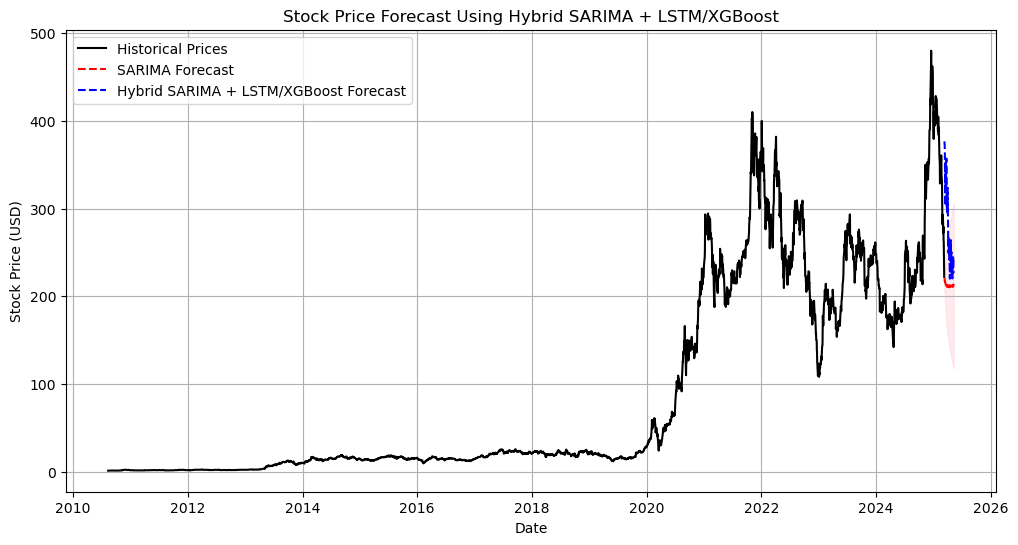

In [50]:
# Ensure xgb_forecast has the same length as future_dates
xgb_forecast = xgb_forecast[:forecast_steps]

# Generate Future Forecasts
forecast_steps = 60
sarima_forecast = sarima_fit.get_forecast(steps=forecast_steps)
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

future_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq="D")[1:]

# Plot Final Forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["y"], label="Historical Prices", color="black")
plt.plot(future_dates, sarima_pred, label="SARIMA Forecast", linestyle="dashed", color="red")

# Ensure the XGBoost forecast length matches the future_dates length
plt.plot(future_dates[:len(xgb_forecast)], xgb_forecast, 
         label="Hybrid SARIMA + LSTM/XGBoost Forecast", linestyle="dashed", color="blue")

plt.fill_between(future_dates, sarima_ci.iloc[:,0], sarima_ci.iloc[:,1], color="pink", alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Stock Price Forecast Using Hybrid SARIMA + LSTM/XGBoost")
plt.legend()
plt.grid(True)
plt.show()


In [57]:
from sklearn.metrics import mean_absolute_error

# Define actual values (Ground Truth) - last known prices before forecasting
actual_values = df["y"].iloc[-len(sarima_pred):].values  # Ensure correct length

# Compare SARIMA & Hybrid predictions
mae_sarima = mean_absolute_error(actual_values, sarima_pred[:len(actual_values)])
mae_hybrid = mean_absolute_error(actual_values, xgb_forecast[:len(actual_values)])

print("MAE SARIMA:", mae_sarima)
print("MAE Hybrid (SARIMA + LSTM/XGBoost):", mae_hybrid)


MAE SARIMA: 166.2377038303305
MAE Hybrid (SARIMA + LSTM/XGBoost): 101.8241013183594
